# Capstone Project 2 - Waste Image Classification

### Importing the necessary libraries

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from warnings import filterwarnings 
filterwarnings("ignore")

### Creating a working directory for TRAIN and TEST data  

In [4]:
# Full base directory
data_dir = r"C:\Users\Siddhant Iyer\OneDrive\Desktop\Imarticus_Learning\DATASET"

# Subdirectories
train_dir = os.path.join(data_dir, 'TRAIN')
test_dir = os.path.join(data_dir, 'TEST')

# Checking for the presence of the file path in the directory
print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))

Train dir exists: True
Test dir exists: True


In [5]:
os.listdir(data_dir)

['TEST', 'TRAIN']

### Visualizing the top 10 images

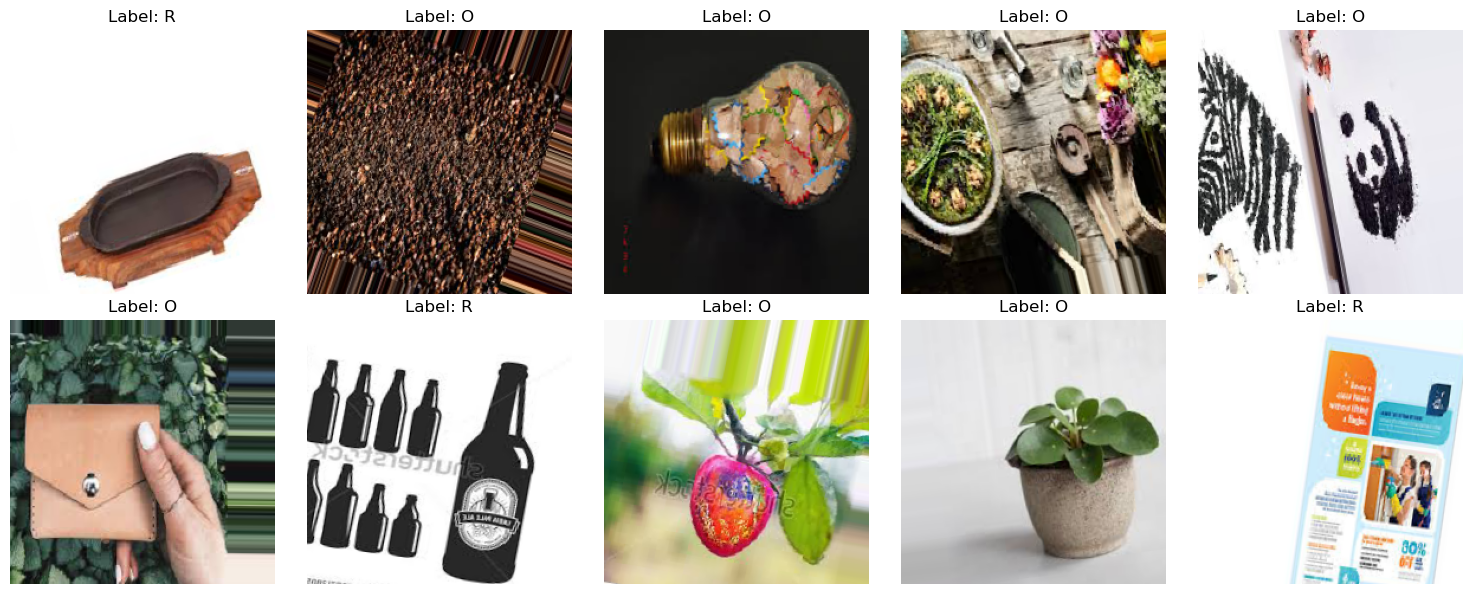

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the generator
images, labels = next(train_generator)

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Plot 10 images (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    label_index = np.argmax(labels[i])
    ax.set_title(f"Label: {class_names[label_index]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [79]:
print(images[i].shape)

torch.Size([3, 224, 224])


### Counting and visualizing number of images in each class

In [20]:
# Creating a user defined function to count images in each class
def count_images_per_class(base_dir):
    for split in ['TRAIN', 'TEST']:
        split_path = os.path.join(data_dir, split)
        print(f"\n📂 In {split} folder:")
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path)
                                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  {class_name}: {num_images} images")

# This counts and prints the number of images in each folder 
count_images_per_class(data_dir)


📂 In TRAIN folder:
  O: 12565 images
  R: 9999 images

📂 In TEST folder:
  O: 1401 images
  R: 1112 images


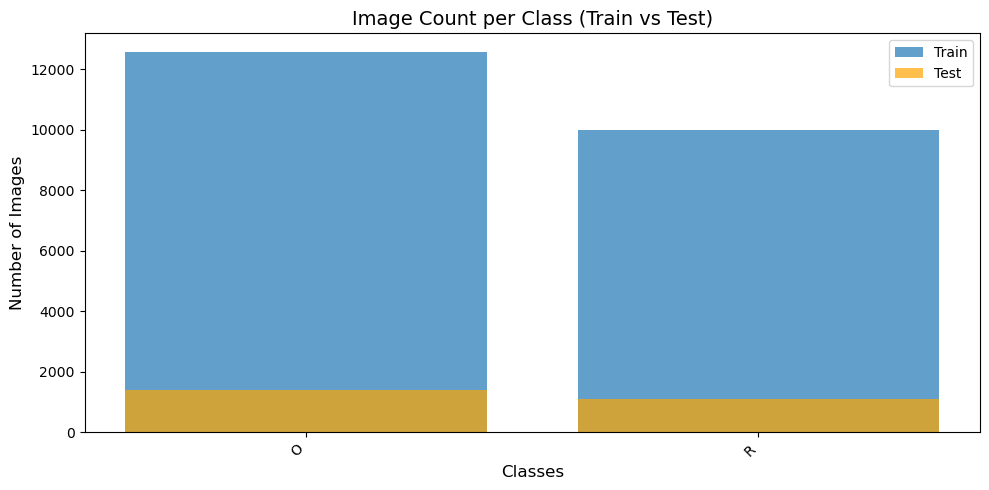

In [21]:
import matplotlib.pyplot as plt

def count_images_per_class(base_dir):
    # Initializing an empty dictionary to hold counts
    class_counts = {'train': {}, 'test': {}}
    
    # Checking if the directories exist
    if not os.path.exists(base_dir):
        print(f"Error: The base directory {base_dir} doesn't exist!")
        return None  # Return None if the directory doesn't exist
    
    # Counting for TRAIN and TEST
    for split in ['TRAIN', 'TEST']:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split} folder doesn't exist at {split_path}")
            continue  # It will skip if the directory doesn't exist

        # Counting the number of image files in each class folder by filtering files that end with '.jpg,.jpeg,.png'
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                class_counts[split.lower()][class_name] = count
    
    # Return the final class_counts dictionary
    return class_counts

# Now, use the function to count images
data_dir = r"C:\Users\Siddhant Iyer\OneDrive\Desktop\Imarticus_Learning\DATASET"
class_counts = count_images_per_class(data_dir)

# If class_counts is None, handle it
if class_counts:
    plot_image_counts(class_counts)
else:
    print("Error: No class counts available. Please check your dataset path and folder structure.")

### Removing corrupted or unreadable images

In [16]:
# Removing corrupted or unreadable images
import cv2

def remove_corrupt_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path) # sees if the image can be opened or is readable or not
                if img is None:
                    os.remove(file_path) # deletes the image from the folder if it cannot be opened
                    removed += 1
            except Exception as e:
                os.remove(file_path)
                removed += 1
    print(f"Removed {removed} corrupt or unreadable images.")

In [18]:
# List of directories to clean
folders_to_clean = [r"C:\Users\Siddhant Iyer\OneDrive\Desktop\Imarticus_Learning\DATASET\TRAIN",
                    r"C:\Users\Siddhant Iyer\OneDrive\Desktop\Imarticus_Learning\DATASET\TEST"]

# Calling the function for each folder
for folder in folders_to_clean:
    remove_corrupt_images(folder)

Removed 0 corrupt or unreadable images.
Removed 0 corrupt or unreadable images.


There were no corrupt or unreadable images present in our data

### Data Augmentation

In [72]:
# Resizing the images to 224 x 224
img_size = (224, 224) 

# Setting the batch_size to 32
batch_size = 32

In [73]:
# Data augmentation for train set and rescaling for validation set

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalization for the train data 
    rotation_range=20, # Rotating the image at a different angle 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of training data used for validation
)

test_datagen = ImageDataGenerator(rescale=1./255) # Normalization for the test data 

### Loading images from the directories

In [74]:
# Creating the training data 
train_generator = train_datagen.flow_from_directory(
    train_dir, # path to the training directory 
    target_size=img_size, # resizing all images to the specified image size (224, 224)
    batch_size=batch_size, 
    class_mode='categorical', # uses one-hot encoding for categorical variables
    subset='training', # this subset is used for training purposes
    shuffle=True, # improve model generalization
    seed=42
)

# Creating the validation data 
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


### Building the Base CNN model

In [75]:
# Creating the CNN model object 

model_cnn = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), # First convolutional layer 
    layers.MaxPooling2D((2, 2)), # Helps reduce spatial dimensions and computations 
    layers.Conv2D(64, (3, 3), activation='relu'), # Second convolutional layer 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'), # Third convolutional layer
    layers.MaxPooling2D((2, 2)), # Extracts higher level features 
    layers.Flatten(), # Flatten layer 
    layers.Dense(512, activation='relu'), # Fully connected Dense layer 
    layers.Dense(2, activation='softmax')  
])

optimizer = Adam(learning_rate = 0.001) # Adam optimizer with learning rate = 0.001

# Compiling the model 

model_cnn.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer=optimizer,
    metrics=['accuracy'] # Evaluation metric
)

# Training the model

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Needed to prevent overfitting

history = model_cnn.fit(       
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 1075s 2s/step - accuracy: 0.7419 - loss: 1.0421 - val_accuracy: 0.7768 - val_loss: 0.4515
Epoch 2/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 17045s 30s/step - accuracy: 0.8260 - loss: 0.4028 - val_accuracy: 0.7912 - val_loss: 0.4214
Epoch 3/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.8283 - loss: 0.3893 - val_accuracy: 0.7945 - val_loss: 0.4395
Epoch 4/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.8374 - loss: 0.3722 - val_accuracy: 0.8167 - val_loss: 0.3839
Epoch 5/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.8576 - loss: 0.3429 - val_accuracy: 0.8287 - val_loss: 0.3715
Epoch 6/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.8525 - loss: 0.3432 - val_accuracy: 0.8373 - val_loss: 0.3698
Epoch 7/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.8621 - loss: 0.3352 - val_accuracy: 0.8375 - val_loss: 0.3705
Epoch 8/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 3486s 6s/step - accuracy: 0.8602 - loss: 0.3395 - val

### Evaluating the Base CNN model

In [77]:
# Evaluate the model on validation data
val_loss, val_accuracy = model_cnn.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.8769 - loss: 0.2988
Validation Loss: 0.3075
Validation Accuracy: 0.8785


- The validation loss for the base CNN model is 0.3075 while the validation is 0.8785
- The total training time required to train this CNN model is 12.8 hours.

------------------------------------------------------------------------------------------------------------------

### Building the Transfer Learning model (MobileNetV2)

In [86]:
# Importing the important libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Loading the base MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

# Adding custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

# Building the model
model_transfer = Model(inputs=base_model.input, outputs=output_layer)
model_transfer.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Training the model
model_transfer.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 945s 2s/step - accuracy: 0.8804 - loss: 0.3179 - val_accuracy: 0.9235 - val_loss: 0.2038
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 444s 786ms/step - accuracy: 0.9215 - loss: 0.1988 - val_accuracy: 0.9326 - val_loss: 0.1761
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 469s 829ms/step - accuracy: 0.9297 - loss: 0.1790 - val_accuracy: 0.9302 - val_loss: 0.1816
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 448s 792ms/step - accuracy: 0.9404 - loss: 0.1579 - val_accuracy: 0.9388 - val_loss: 0.1695
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 442s 781ms/step - accuracy: 0.9412 - loss: 0.1582 - val_accuracy: 0.9426 - val_loss: 0.1617
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 462s 818ms/step - accuracy: 0.9428 - loss: 0.1500 - val_accuracy: 0.9302 - val_loss: 0.1925
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 449s 795ms/step - accuracy: 0.9440 - loss: 0.1449 - val_accuracy: 0.9311 - val_loss: 0.1798
Epoch 8/10
565/565 ━━━━━━━━━━━

### Evaluating the MobileNetV2 model

In [88]:
# Evaluate the model on validation data
val_loss, val_accuracy = model_transfer.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 998ms/step - accuracy: 0.9453 - loss: 0.1542
Validation Loss: 0.1553
Validation Accuracy: 0.9444


- The validation loss for the MobileNetV2 model is 0.1553 which is much lower thna the base CNN model
- The validation accuracy is 0.9444 which is a significant improvement to the base CNN model
- The training time for this model is 1.45 hours which is a drastic decrease in computational expense 

-------------------------------------------------------------------------------------------------------------------

### Building the Ensemble model (CNN + MobileNetV2)

In [93]:
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.models import Model

# Ensuring both models are not trainable 
model_cnn.trainable = False
model_transfer.trainable = False

# Shared input layer
ensemble_input = Input(shape=(224, 224, 3))

# Getting predictions from both models
cnn_output = model_cnn(ensemble_input)
transfer_output = model_transfer(ensemble_input)

# Averaging the predictions (soft voting)
ensemble_output = Average()([cnn_output, transfer_output])

# Final ensemble model
ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_output)

# Compiling the model
ensemble_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [94]:
loss, accuracy = ensemble_model.evaluate(validation_generator)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9449 - loss: 0.1869
Validation Loss: 0.1912
Validation Accuracy: 0.9419


- The validation loss for the ensemble model is 0.1912 which is definitely lower than the base CNN model but slightly higher than the MobileNetV2 model
- The validation accuracy is 0.9419 is marginally lower compared to the MobileNetV2 model
- The output time is like 173s which is understood given that it is just combining the predictions of two trained models.

---------------------------------------------------------------------------------------------------------------------

### Comparing Model Performance

In [127]:
import pandas as pd

# Manually entering the validation accuracy and loss values for each model and storing it in a DataFrame for comparing
data = {
    'Model Name': ['Base CNN', 'MobileNetV2', 'Ensemble'],
    'Validation Accuracy': [0.8785, 0.9444, 0.9419],  
    'Validation Loss': [0.3075, 0.1553, 0.1912], 
    'Training Time (hrs)': [12.8, 1.45, 0.00139] 
}

df_results = pd.DataFrame(data)

print(df_results)

    Model Name  Validation Accuracy  Validation Loss  Training Time (hrs)
0     Base CNN               0.8785           0.3075             12.80000
1  MobileNetV2               0.9444           0.1553              1.45000
2     Ensemble               0.9419           0.1912              0.00139


#### From the validation accuracy scores and loss values of the three different models built, we can conclude that the MobileNetV2 model performed the best. It gave a validation accuracy score of 0.9444 and it was computationally less expensive to build than the base CNN model. This MobileNetV2 will therefore be deployed using Gradio for waste classification purposes.

### Saving the three models permanently

In [123]:
# Saving the three models just in case we want to use either one of them in the future
model_cnn.save('cnn_model_waste_classifier.keras')
model_transfer.save('mobilenetv2_waste_classifier.keras')
ensemble_model.save('ensemble_model_waste_classifier.keras')

### Making Predictions on the Test Set using MobileNetV2

In [101]:
from tensorflow.keras.models import load_model

# Loading the saved model
model = load_model('mobilenetv2_waste_classifier.keras')

In [102]:
# Creating the test data
img_size = (224,224)
batch_size = 32 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 2513 images belonging to 2 classes.


In [103]:
# Making predictions on the test data 
predictions = model_transfer.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping predicted classes to category names
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[i] for i in predicted_classes]

79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 793ms/step


### Displaying the first few images along with their predicted labels

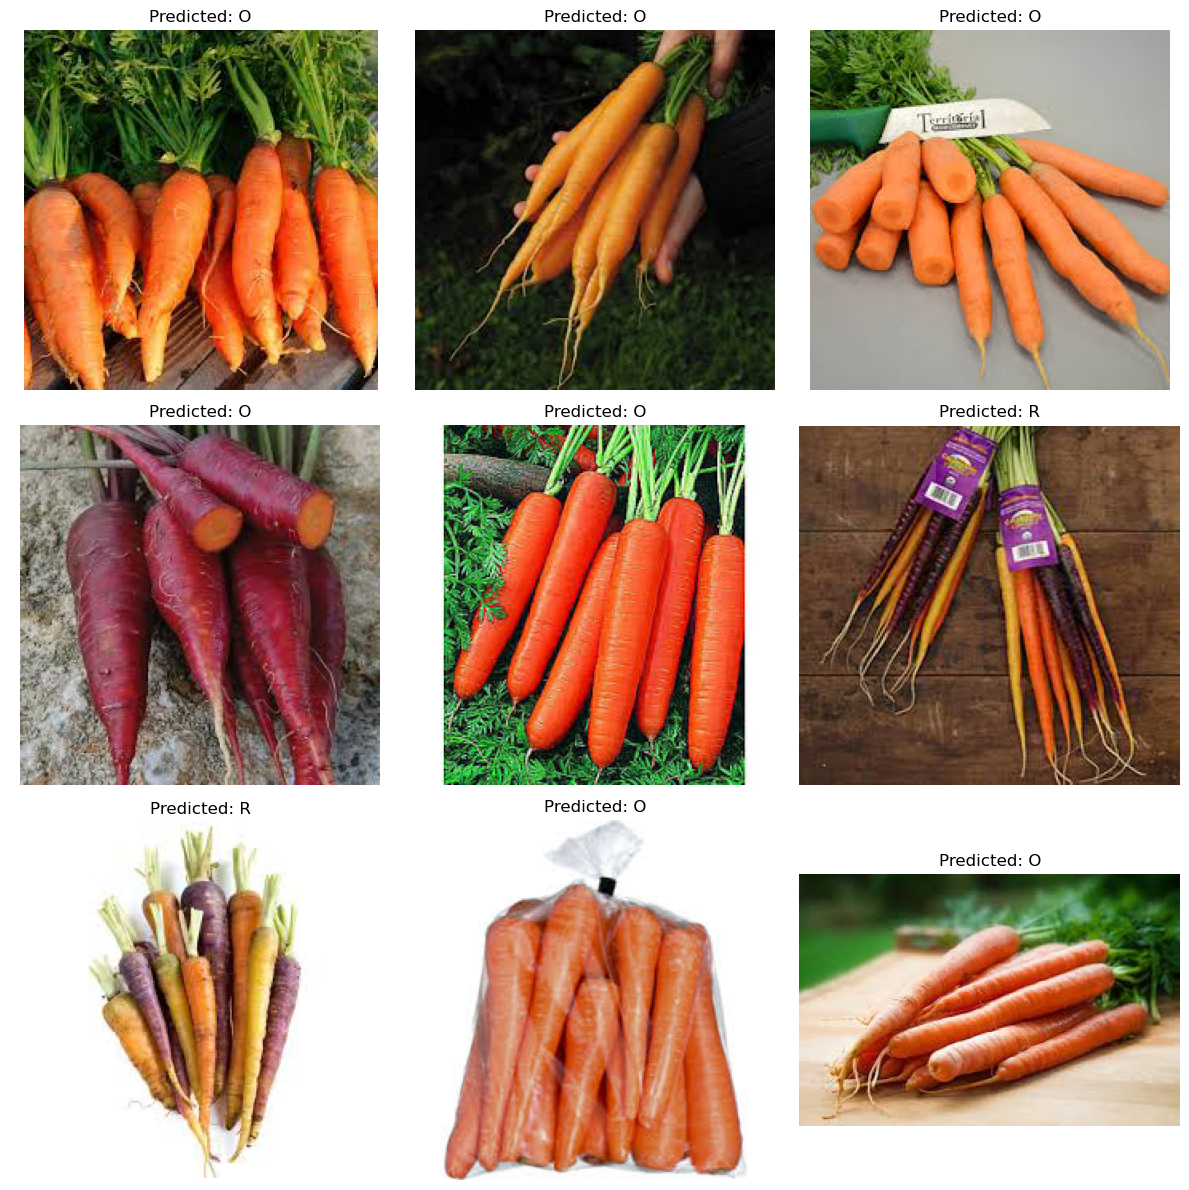

In [104]:
# Folder where test images are stored
image_paths = test_generator.filepaths  # full paths to the test images

# Displaying first 9 images with predicted labels
plt.figure(figsize=(12, 12))
for i in range(9):
    img = plt.imread(image_paths[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

- From the images of displayed above, we can see that the MobileNetV2 model is doing a fairly good job at classifying the images into the different categories.
- There are a few misclassifications but it is understood given that the model does not have 100% accuracy
- The model can now be deployed to build the Gradio user inteface

---------------------------------------------------------------------------------------------------------------

### Deploying the MobileNetV2 model using Gradio

In [106]:
class_labels = ['Organic','Recyclable']

In [119]:
# Creating a prediction function

import numpy as np
from tensorflow.keras.preprocessing import image

def predict_waste(img):
    # Resizing image to model input size
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Making prediction on class labels 
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    return predicted_class

In [120]:
# Building the Gradio Interface

import gradio as gr

# Creating the Gradio user interface
interface = gr.Interface(
    fn=predict_waste,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Waste Classification App",
    description="Upload an image to classify it as Organic or Recyclable"
)

# Launching the app
interface.launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


--------------------------------------------------------------------------------------------------------------------